### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3

 ### 2 Reading Data

In [3]:
db_path = "/home/Assignment/02_training_pipeline/notebooks/"
data = "/home/airflow/dags/lead_scoring_data_pipeline/lead_scoring_data_cleaning.db"

db_file = "lead_scoring_model_experimentation.db"

In [4]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
try:
    conn = sqlite3.connect(data)
    query = f"SELECT * FROM {'model_input'}"
    dataset = pd.read_sql_query(query, conn)
except sqlite3.Error as e:
    print(f"Database error: {e}")
except pd.errors.EmptyDataError:
    print(f"Table '{table_name}' is empty.")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    if conn:
        conn.close()  

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 19.6 µs


In [5]:
dataset.head()

,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_dropped,city_tier,referred_lead,app_complete_flag
0,Level0,Level11,Level2,1.0,1.0,0.0,1
1,Level3,Level0,others,1.0,2.0,0.0,1
2,Level3,Level0,Level0,1.0,1.0,0.0,1
3,Level1,Level3,others,2.0,1.0,0.0,0
4,Level3,Level0,Level0,1.0,1.0,0.0,0


In [6]:
# drop the data column as it is not needed for training
#dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [7]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
conn = None
 # opening the conncetion for creating the sqlite db
try:
    conn = sqlite3.connect(db_path+db_file)
    print(sqlite3.version)
 # return an error if connection not established
except Error as e:
    print(e)
 # closing the connection once the database is created
finally:
    if conn:
        conn.close()

2.6.0


In [8]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [5]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [6]:

dataset = dataset.sample(frac=0.1)
data_for_model = dataset.sample(frac=(1-0.01), random_state=786)
data_unseen = data_for_model.drop(data_for_model.index)
data_for_model.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

### 4 : Model Experimentation with pycaret

In [32]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
Lead_Scoring_Training_Pipeline = setup(data = data_for_model, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Lead_Scoring_Training_Pipeline',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)
best_model = compare_models(exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7213,0.7683,0.8833,0.7106,0.7843,0.4024,0.4282,0.0250
rf,Random Forest Classifier,0.7151,0.7688,0.8522,0.7133,0.7709,0.3978,0.4265,0.7400
lda,Linear Discriminant Analysis,0.7151,0.7599,0.8511,0.7168,0.7742,0.3944,0.4085,0.0100
ridge,Ridge Classifier,0.7022,0.0000,0.8711,0.6902,0.7685,0.3626,0.3838,0.0120
lightgbm,Light Gradient Boosting Machine,0.6779,0.7432,0.7856,0.6959,0.7345,0.3252,0.3295,2.1520
nb,Naive Bayes,0.6434,0.7160,0.7700,0.6632,0.7003,0.2611,0.2784,0.0090
xgboost,Extreme Gradient Boosting,0.6246,0.7533,0.7122,0.6695,0.6812,0.2173,0.2172,0.1970
dt,Decision Tree Classifier,0.5632,0.6553,0.5856,0.6237,0.5919,0.1187,0.1154,0.0090
et,Extra Trees Classifier,0.5471,0.6605,0.5756,0.6067,0.5774,0.0804,0.0794,0.7930


In [33]:
# create a model which gives the highest accuracy
lr  = create_model('lr', fold = 5) 

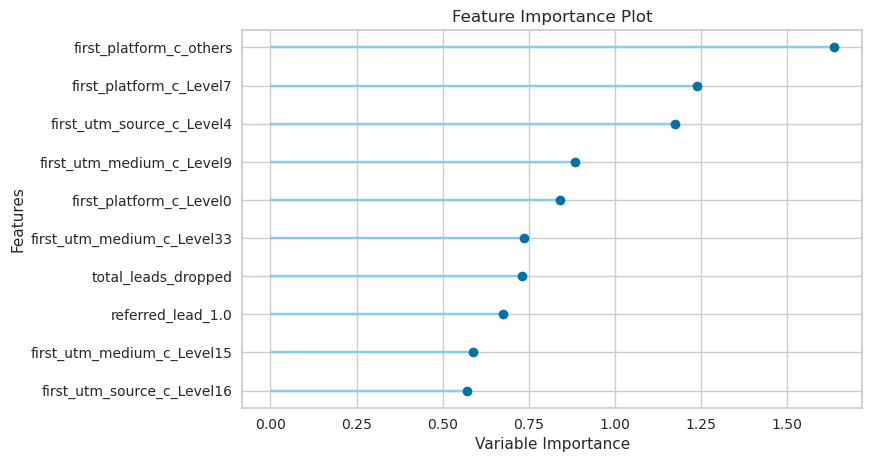

In [34]:
# create feature importance plot
plot_model(lr, plot='feature') #feature_all -> to check for all features 

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [10]:
# One-hot encode only selected columns
from sklearn.preprocessing import OneHotEncoder
FEATURES_TO_ENCODE = ['city_tier', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
df_encoded = pd.get_dummies(data_for_model, columns=FEATURES_TO_ENCODE, drop_first=False)
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(data_for_model[FEATURES_TO_ENCODE])
print(encoder.get_feature_names(FEATURES_TO_ENCODE))

['city_tier_1.0' 'city_tier_2.0' 'city_tier_3.0' 'first_platform_c_Level0'
 'first_platform_c_Level1' 'first_platform_c_Level2'
 'first_platform_c_Level3' 'first_platform_c_Level7'
 'first_platform_c_Level8' 'first_platform_c_others'
 'first_utm_medium_c_Level0' 'first_utm_medium_c_Level10'
 'first_utm_medium_c_Level11' 'first_utm_medium_c_Level13'
 'first_utm_medium_c_Level15' 'first_utm_medium_c_Level16'
 'first_utm_medium_c_Level2' 'first_utm_medium_c_Level20'
 'first_utm_medium_c_Level26' 'first_utm_medium_c_Level3'
 'first_utm_medium_c_Level30' 'first_utm_medium_c_Level33'
 'first_utm_medium_c_Level4' 'first_utm_medium_c_Level43'
 'first_utm_medium_c_Level5' 'first_utm_medium_c_Level6'
 'first_utm_medium_c_Level8' 'first_utm_medium_c_Level9'
 'first_utm_medium_c_others' 'first_utm_source_c_Level0'
 'first_utm_source_c_Level14' 'first_utm_source_c_Level16'
 'first_utm_source_c_Level2' 'first_utm_source_c_Level4'
 'first_utm_source_c_Level5' 'first_utm_source_c_Level6'
 'first_utm_s

In [11]:
# 
feature_cols = ['total_leads_dropped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
train_dataset = data_for_model[feature_cols]
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

Lead_Scoring_Training_Pipeline = setup(data = train_dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Lead_Scoring_Training_Pipeline',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   normalize=False, transformation=False,
                   log_profile=False)


,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(23657, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [12]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7343,0.8161,0.8402,0.6937,0.7598,0.4687,0.4798,0.3120
rf,Random Forest Classifier,0.7342,0.8159,0.8439,0.6923,0.7605,0.4684,0.4803,0.7990
lightgbm,Light Gradient Boosting Machine,0.7336,0.8184,0.8395,0.6930,0.7591,0.4671,0.4783,2.8270
et,Extra Trees Classifier,0.7258,0.8030,0.8107,0.6934,0.7473,0.4516,0.4585,1.2170
dt,Decision Tree Classifier,0.7250,0.8007,0.8096,0.6928,0.7465,0.4501,0.4569,0.0410
lr,Logistic Regression,0.7098,0.7838,0.8171,0.6730,0.7380,0.4196,0.4297,0.2140
ridge,Ridge Classifier,0.7013,0.0000,0.7962,0.6694,0.7272,0.4026,0.4102,0.0520
lda,Linear Discriminant Analysis,0.7013,0.7740,0.7962,0.6694,0.7272,0.4026,0.4102,0.0940
nb,Naive Bayes,0.6842,0.7368,0.8510,0.6382,0.7293,0.3683,0.3909,0.0240


In [13]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm  = create_model('lightgbm', fold = 5) 

In [15]:
!pip install optuna

  Using cached optuna-4.3.0-py3-none-any.whl (386 kB)


In [17]:
#!pip install optuna-integration[sklearn]
!pip install optuna-integration

  Using cached optuna_integration-4.3.0-py3-none-any.whl (98 kB)


In [19]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
from optuna.distributions import IntDistribution

custom_grid = {
    'actual_estimator__num_leaves': IntDistribution(10, 100)
}

tuned_lgbm_optuna,tuner_1 = tune_model(lgbm, 
                                    search_library='optuna',
                                    fold = 10,
                                    custom_grid=custom_grid,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [21]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
tuner_1

OptunaSearchCV(callbacks=None, catch=(),
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         device='gpu',
                                                         importance_type='split',
                                                         learnin...
               param_distributions={'actual_estimator__actual_estimator__num_leaves': IntDistribution(high=100, log=False, low=10, step=1)},
               random_state=42, refit=Fals